## Business problem
- we have retail store data we can check for  
a) customer segmentation  
b) market basket analysis  
c) RFM analysis

### Data Set information


- contains  the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. `Many customers` of the company are wholesalers.


[Attribute Information](https://archive.ics.uci.edu/ml/datasets/online+retail#):

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. **If this code starts with letter 'c', it indicates a cancellation.**
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer reside

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
import datetime as dt
import time, warnings
warnings.filterwarnings('ignore')

#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale, StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.svm import SVC

In [2]:
#loading the xlsx file

df=pd.read_excel('.\Online Retail.xlsx')
df['Total Price']=df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Exploratory Data Analysis

some missing value are present in Description and customer id

---


In [3]:
#check of datatype and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   Total Price  541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 37.2+ MB


---
Unit price and Quantity have negative value

In [4]:
#summary statistics
#df.describe(include='all')
df.describe()

,Quantity,UnitPrice,CustomerID,Total Price
count,541909.000000,541909.000000,406829.000000,541909.000000
mean,9.552250,4.611114,15287.690570,17.987795
std,218.081158,96.759853,1713.600303,378.810824
min,-80995.000000,-11062.060000,12346.000000,-168469.600000
25%,1.000000,1.250000,13953.000000,3.400000
50%,3.000000,2.080000,15152.000000,9.750000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [5]:
#number of customers that cancelled order
print('there are :',df['InvoiceNo'].str.contains('C').sum(), ' orders cancelled, which contribute to ', round(df['InvoiceNo'].str.contains('C').sum()/len(df)*100,2),' % of the dataset.')

there are : 9288  orders cancelled, which contribute to  1.71  % of the dataset.


In [6]:
# dimesion of matrix
df.shape

(541909, 9)

In [7]:
#check for missing value ration value in columns
#df.isnull().sum()/df.shape[0]*100
df.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
Total Price     0.000000
dtype: float64

In [8]:
#check for unique values in columns
#df.T.apply(lambda x: x.nunique(), axis=1)
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
Total Price     6204
dtype: int64

In [9]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Total Price'],
      dtype='object')

### Exploratory Data analysis

**1. frequency of order by month**

we can use [various other forms](https://stackoverflow.com/questions/60214194/error-in-reading-stock-data-datetimeproperties-object-has-no-attribute-week) to extract day, month, year from time

In [10]:
df1= df.copy()
df1['year']=df1['InvoiceDate'].dt.year
df1['month']=df1['InvoiceDate'].dt.month
df1['Year_month']=df1['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))
df1['day_of_week']= df1['InvoiceDate'].dt.day_name()

df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price,year,month,Year_month,day_of_week
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,2010-12,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,2010-12,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,2010-12,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,2010-12,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,2010-12,Wednesday


**since our `InvoiceNo`has some missing value also. so to treat [Missing Values](https://stackoverflow.com/questions/52297740/typeerror-bad-operand-type-for-unary-float)**

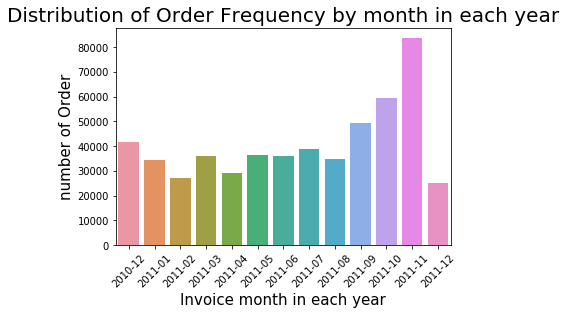

In [11]:
sns.countplot(x='Year_month',data=df1[~df1['InvoiceNo'].str.startswith('C',na=False)] )
plt.title('Distribution of Order Frequency by month in each year', fontsize=20)
plt.xlabel('Invoice month in each year',fontsize=15)
plt.ylabel('number of Order',fontsize=15)
plt.xticks(rotation=45)
plt.show()

most of the order are placed at the end of each year. it could be due to christmas and thanksgiving

**2. Cancelled order by month**

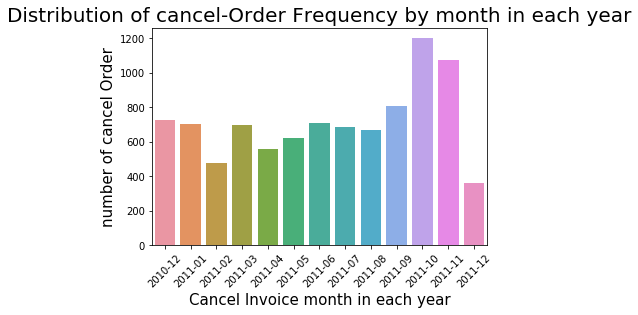

In [12]:
sns.countplot(x='Year_month',data=df1[df1['InvoiceNo'].str.startswith('C',na=False)])
plt.title('Distribution of cancel-Order Frequency by month in each year', fontsize=20)
plt.xlabel('Cancel Invoice month in each year',fontsize=15)
plt.ylabel('number of cancel Order',fontsize=15)
plt.xticks(rotation=45)
plt.show()

it can be seen that most of the cancelled orders are also found in last months of the year such as `october`has many cancelled order

**3. Frequency of order by days in week**

In [13]:
#converting day_f_week from object to categorical variable
df1['day_of_week'] = pd.Categorical(df1['day_of_week'], categories=[ 'Sunday', 'Monday','Tuesday','Wednesday',
                                                                  'Thursday','Friday','Saturday'], ordered=True)

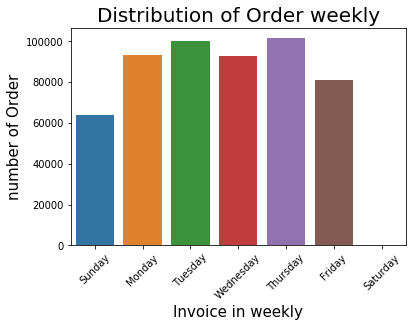

In [14]:
sns.countplot(x='day_of_week',data=df1[~df1['InvoiceNo'].str.startswith('C',na=False)])
plt.title('Distribution of Order weekly', fontsize=20)
plt.xlabel('Invoice in weekly',fontsize=15)
plt.ylabel('number of Order',fontsize=15)
plt.xticks(rotation=45)
plt.show()

**4. Countries with large number of orders and customers**

In [15]:
df_order=df1.groupby('Country',as_index=False)['InvoiceNo','CustomerID'].count().sort_values(['InvoiceNo','CustomerID'],ascending= False)
df_order.columns=['Country','TotalOrder','TotalCustomer']
df_order

,Country,TotalOrder,TotalCustomer
36,United Kingdom,495478,361878
14,Germany,9495,9495
13,France,8557,8491
10,EIRE,8196,7485
31,Spain,2533,2533
24,Netherlands,2371,2371
3,Belgium,2069,2069
33,Switzerland,2002,1877
27,Portugal,1519,1480
0,Australia,1259,1259


**5. Distribution of total orders in world map**

In [16]:
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

In [17]:
data = dict(type='choropleth',
            locations = df_order['Country'],
            locationmode = 'country names', z = df_order['TotalOrder'],
            text = df_order['Country'], colorbar = {'title':'TotalOrders'},
            colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]], reversescale = True,
            marker = dict(line = dict (color = 'rgb(180,180,180)',width = 0.5))
           )

In [18]:
layout = dict(title='Order Frequency by Country',
geo = dict(showframe=False,projection={'type':'equirectangular'}))

In [19]:
import plotly.graph_objs as go
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

**6. Countries with more number of customer have highest average spending per order**

In [20]:
df1_highspender= df1.groupby('Country', as_index=False)['Total Price'].agg({'Total Spent':sum,
                                                                            'Average Price':np.mean}).sort_values(by=['Average Price'], ascending= False)

df1_highspender['Average Price']=round(df1_highspender['Average Price'],2)
df1_highspender['Total Spent']=round(df1_highspender['Total Spent'],2)

df1_highspender

,Country,Total Spent,Average Price
24,Netherlands,284661.54,120.06
0,Australia,137077.27,108.88
20,Japan,35340.62,98.72
32,Sweden,36595.91,79.21
9,Denmark,18768.14,48.25
22,Lithuania,1661.06,47.46
30,Singapore,9120.39,39.83
21,Lebanon,1693.88,37.64
4,Brazil,1143.60,35.74
16,Hong Kong,10117.04,35.13


**7.Word frequency of Product Description**

In [21]:
# get all production description
import re
product_description = df1.Description.unique()

In [22]:
all_product_list = []
for s in product_description:
    # Search for all non-letters
    letters_only = re.sub("[^a-zA-Z]",  
                          " ",   # Replace all non-letters with spaces
                          str(s))
    letters_only = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", letters_only) # remove numbers in the product description
    all_product_list.append(letters_only)
    
print(all_product_list[:5])

['WHITE HANGING HEART T LIGHT HOLDER', 'WHITE METAL LANTERN', 'CREAM CUPID HEARTS COAT HANGER', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART ']


In [23]:
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from collections import Counter
import operator

---

**list of all the stopwords in nltk for language English**

In [24]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#print(stop_words)

--- 

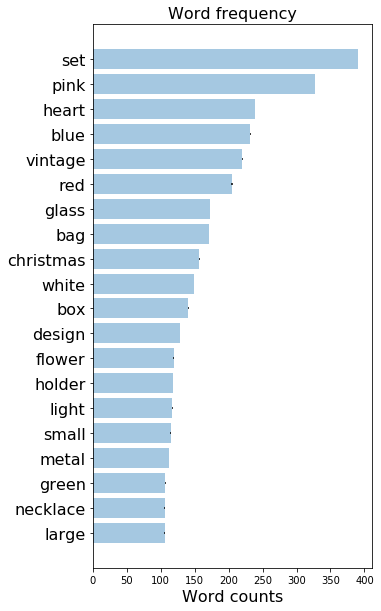

In [25]:
#split string into words and converted lower
gen_docs = [[w.lower() for w in word_tokenize(text)] 
            for text in all_product_list]

# make all tokenized word in a list
flat_list = [item for sublist in gen_docs for item in sublist]

# remove stop word from counts
stopset = list(set(stopwords.words('english')))
word_list = []
for w in flat_list:
    if w not in stopset:
        word_list.append(w)

# count frequency for each word
counts = Counter(word_list)
#counts = {k:counts[k] for k in counts if counts[k] > 147}#.most_common()
#print(counts)

# sort word by frequency 
sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=False)
sorted_counts = sorted_counts[-20:]
keys = [val[0] for val in sorted_counts]
y_pos = np.arange(len(sorted_counts))
performance = [val[1] for val in sorted_counts]
error = np.random.rand(len(keys))

fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(111)
ax.barh(y_pos, performance, xerr=error, align='center', alpha=0.4)
#plt.subplots(figsize=(20, 10))

plt.yticks(y_pos, keys,fontsize=16)
plt.xlabel('Word counts', fontsize=16)
plt.title('Word frequency', fontsize=16)

plt.show()

NLP is not giving huge information

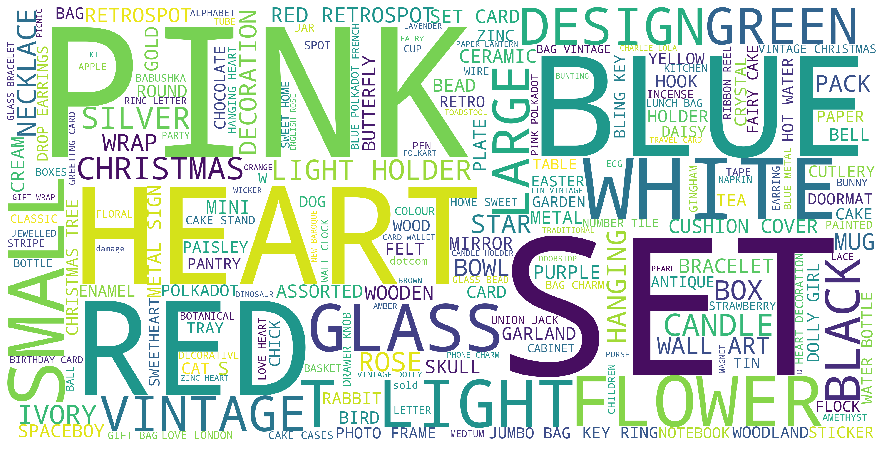

In [26]:
# Create a wordcloud of the product Description
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

words_frame = pd.DataFrame (all_product_list,columns=['Words occurence'])
words_frame['Words occurence'] = words_frame['Words occurence'].fillna("").astype('str')
Description_corpus = ' '.join(words_frame['Words occurence'])
description_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(Description_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(description_wordcloud)
plt.axis('off')
plt.show()

### Introduction
In ecommerce industries,customer segmentation is helpful to understand customer behaviour.    
our Goal in this notebook are

- increasing revenue 
- increasing customer retention
- customers at risk and some trends and patterns
- we will perform RFM analysis which answers question like
        -- who are best customers
        -- who can be converted to most potential/ profiatble customer
        -- who must we retain
        -- which group of customer respond to our current campaigns

#### As customer cluster may vary geographically so let's consider first United Kingdom for this example `As comparitively UK has many customerIds`

In [27]:
#only taking UK for ananlysis purpose
df_UK=df[df['Country']=='United Kingdom']
df_UK.shape

(495478, 9)

In [28]:
#check for missing value ratio value in columns
df_UK.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.293454
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     26.963861
Country         0.000000
Total Price     0.000000
dtype: float64

In [29]:
#droping null from CustomerID
df_UK.dropna(subset=['CustomerID'],how='all',inplace=True)
df_UK.shape

(361878, 9)

In [30]:
#remove all cancelled order
df_UK=df_UK[df_UK['Quantity']>0]
df_UK.shape

(354345, 9)

In [31]:
#taking all order inofrmation from 9.dec.2010
df_UK=df_UK[df_UK['InvoiceDate']>= "2010-12-09"]
df_UK.shape

(342478, 9)

In [32]:
#unique in each column
df_UK.nunique()

InvoiceNo      16017
StockCode       3611
Description     3799
Quantity         289
InvoiceDate    15040
UnitPrice        396
CustomerID      3863
Country            1
Total Price     2751
dtype: int64

In [33]:
df_UK.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,47.4
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,37.2
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,15.3
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,31.8
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,15.9


In [34]:
#top few product that has been sold
uk_product = df_UK.groupby(['StockCode','Description'],as_index= False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
uk_product.head(10)

,StockCode,Description,Quantity
2492,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
1994,23166,MEDIUM CERAMIC TOP STORAGE JAR,76919
2663,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,45486
3508,85099B,JUMBO BAG RED RETROSPOT,40672
3515,85123A,WHITE HANGING HEART T-LIGHT HOLDER,33073
2766,84879,ASSORTED COLOUR BIRD ORNAMENT,31379
1019,22197,POPCORN HOLDER,28935
1413,22616,PACK OF 12 LONDON TISSUES,23418
37,17003,BROCADE RING PURSE,21736
999,22178,VICTORIAN GLASS HANGING T-LIGHT,21557


above we can see top 10 products that sold most on UK

In [35]:
#no of missing customer id in UK
print("Percentage of customers NA: ", round(df_UK['CustomerID'].isnull().sum() * 100 / len(df_UK),2),"%" )

Percentage of customers NA:  0.0 %


### RFM analysis
- RFM stands for RECENCY(R) **days since last purchase**
- FREQUENCY(F) **total number of purchase**
- MONETARY VALUE(M) **amount of money spent by customer**


In [36]:
#create a column that has only invoiceDate without timestamp
df_UK['date']=df_UK['InvoiceDate'].dt.date
df_UK.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price,date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,47.4,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,37.2,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,15.3,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,31.8,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,15.9,2010-12-09


### RECENY

In [37]:
# check for last date of purchase
recency_df_UK= df_UK.groupby(by='CustomerID',as_index=False)['date'].max()
recency_df_UK.columns = ['CustomerID','LastPurshaceDate']
recency_df_UK.head()

,CustomerID,LastPurshaceDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [38]:
df_UK['InvoiceDate'].max()  

Timestamp('2011-12-09 12:49:00')

In [39]:
now=dt.date(2011,12,9)
print(now)

2011-12-09


In [40]:
#calculate recency
recency_df_UK['Recency'] = recency_df_UK['LastPurshaceDate'].apply(lambda x: (now - x).days)
recency_df_UK.head(10)

,CustomerID,LastPurshaceDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3
5,12821.0,2011-05-09,214
6,12822.0,2011-09-30,70
7,12823.0,2011-09-26,74
8,12824.0,2011-10-11,59
9,12826.0,2011-12-07,2


In [41]:
#delete LastPurchaseDate as we don't need it anymore
recency_df_UK.drop('LastPurshaceDate',axis=1,inplace=True)

### FREQUENCY

In [42]:
df_UK_copy= df_UK

#remove duplicates from customer and invoices only keep first
df_UK_copy.drop_duplicates(subset=['InvoiceNo','CustomerID'],keep='first',inplace=True)

#calculate frequency of purchase
frequency_df_UK=df_UK_copy.groupby(by=['CustomerID'],as_index=False)['InvoiceNo'].count()
frequency_df_UK.columns=['CustomerID','Frequency']
frequency_df_UK.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


### Monetary value

In [43]:
#how much customer spent
df_UK['total_amount']= df_UK['UnitPrice']*df_UK['Quantity']

In [44]:
monetary_df_UK=df_UK.groupby(by='CustomerID',as_index=False).agg({'total_amount':'sum'})
monetary_df_UK.columns=['CustomerID','Monetary']
monetary_df_UK.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


### RFM TABLE

In [45]:
temp=recency_df_UK.merge(frequency_df_UK,on='CustomerID')
temp.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12747.0,2,10
2,12748.0,0,196
3,12749.0,3,5
4,12820.0,3,4


In [46]:
# now merge monetary table
RFM_df_UK=temp.merge(monetary_df_UK,on='CustomerID')
RFM_df_UK.set_index('CustomerID',inplace=True)
RFM_df_UK.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


In [47]:
#check for correctness of RFM table
df_UK[df_UK['CustomerID']==12820.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price,date,total_amount
59368,541283,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2011-01-17 12:34:00,0.55,12820.0,United Kingdom,13.2,2011-01-17,13.2
360567,568236,23328,SET 6 SCHOOL MILK BOTTLES IN CRATE,4,2011-09-26 11:49:00,3.75,12820.0,United Kingdom,15.0,2011-09-26,15.0
420111,572873,23436,VINTAGE CHRISTMAS GIFT BAG LARGE,12,2011-10-26 13:27:00,1.25,12820.0,United Kingdom,15.0,2011-10-26,15.0
531846,580973,21098,CHRISTMAS TOILET ROLL,12,2011-12-06 15:12:00,1.25,12820.0,United Kingdom,15.0,2011-12-06,15.0


As we can see that this id occur 4 times and generate the total amount as 58.2

### Customer segementation with RFM model
- first of all we will check for pareto commonly referred to as 80-20 rule which say that 20% of contribution can bring out 80% results 

#### Applying 80-20 rule

In [48]:
print('pareto_cutoff upto 2 decimal:\n',round(RFM_df_UK['Monetary'].sum()*0.8,2))

pareto_cutoff upto 2 decimal:
 890679.54


In [49]:
#rannking of customers on basis of revenue generation
RFM_rank=RFM_df_UK
RFM_rank['Rank']=RFM_rank['Monetary'].rank(ascending=False)
RFM_rank.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,10,658.89,183.0
12748.0,0,196,3739.23,34.0
12749.0,3,5,98.35,1140.0
12820.0,3,4,58.20,1665.5


#### Top Customers

In [50]:
RFM_rank.sort_values('Rank',ascending=True)

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
16446.0,0,2,168471.25,1.0
12346.0,325,1,77183.60,2.0
15098.0,182,3,39916.50,3.0
18102.0,0,57,39646.45,4.0
17949.0,1,44,28685.69,5.0
...,...,...,...,...
15503.0,362,1,0.42,3859.5
15645.0,18,1,0.42,3859.5
17914.0,3,1,0.39,3861.5


In [51]:
top_20_cutoff=3863*0.20
top_20_cutoff

772.6

In [52]:
#sum the monetary values over the customer with rank <=773
rev_top_20= RFM_rank[RFM_rank['Rank']<=772]['Monetary'].sum()
rev_top_20

976683.3499999999

In this case,80% of total revenue is more or less achieved by 20% of Top customers. it would be interesting to study about this group.

### Applying RFM score formula
In here we will apply a score of 1 to 4 to Recency, Frequency and Monetary value where 4 is considered to be best and 1 as worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

#### RFM quartiles
    

In [53]:
quantile=RFM_df_UK.quantile(q=[0.25,0.5,0.75])
quantile

,Recency,Frequency,Monetary,Rank
0.25,17.0,1.0,17.4,966.5
0.50,49.0,2.0,45.0,1930.5
0.75,134.0,5.0,121.6,2898.0


In [54]:
quantile.to_dict()

{'Recency': {0.25: 17.0, 0.5: 49.0, 0.75: 134.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.4, 0.5: 45.0, 0.75: 121.6},
 'Rank': {0.25: 966.5, 0.5: 1930.5, 0.75: 2898.0}}

### creation of RFM segmentation table

In [55]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [56]:
rfm_segmentation = RFM_df_UK
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantile,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantile,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantile,))

In [57]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4
12747.0,2,10,658.89,183.0,4,4,4
12748.0,0,196,3739.23,34.0,4,4,4
12749.0,3,5,98.35,1140.0,4,3,3
12820.0,3,4,58.20,1665.5,4,3,3


Now that we have the score of each customer, we can represent our customer segmentation.

First, we need to combine the scores (R_Quartile, F_Quartile,M_Quartile) together.

In [58]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4,114
12747.0,2,10,658.89,183.0,4,4,4,444
12748.0,0,196,3739.23,34.0,4,4,4,444
12749.0,3,5,98.35,1140.0,4,3,3,433
12820.0,3,4,58.20,1665.5,4,3,3,433


Best Recency score = 4 `most recently purchase`  
Best Frequency score = 4 `most quantity purchase`   
Best Monetary score = 4 `spent the most`  

Let's see who are our best customers

In [59]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
18102.0,0,57,39646.45,4.0,4,4,4,444
17949.0,1,44,28685.69,5.0,4,4,4,444
17450.0,8,44,25953.51,6.0,4,4,4,444
16013.0,3,45,17163.28,8.0,4,4,4,444
16333.0,7,22,14418.96,9.0,4,4,4,444
15769.0,7,25,11660.84,11.0,4,4,4,444
12901.0,8,28,9230.45,12.0,4,4,4,444
13798.0,1,56,7786.26,13.0,4,4,4,444
16684.0,4,28,7700.08,14.0,4,4,4,444


How many customers do we have in each segment?

In [60]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']), "--->",round(len(rfm_segmentation[rfm_segmentation['RFMScore']=='444'])/len(rfm_segmentation)*100,2),"%")
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]), "--->",round(len(rfm_segmentation[rfm_segmentation['F_Quartile']==4])/len(rfm_segmentation)*100,2),"%")
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]), "--->",round(len(rfm_segmentation[rfm_segmentation['M_Quartile']==4])/len(rfm_segmentation)*100,2),"%")
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']), "--->",round(len(rfm_segmentation[rfm_segmentation['RFMScore']=='244'])/len(rfm_segmentation)*100,2),"%")
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']), "--->",round(len(rfm_segmentation[rfm_segmentation['RFMScore']=='144'])/len(rfm_segmentation)*100,2),"%")
print('Lost less spending Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']), "--->",round(len(rfm_segmentation[rfm_segmentation['RFMScore']=='111'])/len(rfm_segmentation)*100,2),"%")

Best Customers:  356 ---> 9.22 %
Loyal Customers:  752 ---> 19.47 %
Big Spenders:  966 ---> 25.01 %
Almost Lost:  64 ---> 1.66 %
Lost Customers:  9 ---> 0.23 %
Lost less spending Customers:  353 ---> 9.14 %


There are huge number of Big spenders and loyal customers and minimal lost Customers

In [61]:
def classifier(CustomerID , RFMScore, F_Quartile, M_Quartile, data):
    if(data[RFMScore][CustomerID]=='444'):
        return 'Best'
    elif(data[F_Quartile][CustomerID]==4):
        return 'Loyal'
    elif(data[M_Quartile][CustomerID]==4):
        return 'BigSpenders'
    elif(data[RFMScore][CustomerID]=='244'):
        return 'AlmostLost'
    elif(data[RFMScore][CustomerID]=='144'):
        return 'Lost'
    elif(data[RFMScore][CustomerID]=='111'):
        return 'LostCheap'
    else:
        return 'Others'

In [62]:
classify_cust=rfm_segmentation.copy()

In [63]:
classify_cust.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4,114
12747.0,2,10,658.89,183.0,4,4,4,444
12748.0,0,196,3739.23,34.0,4,4,4,444
12749.0,3,5,98.35,1140.0,4,3,3,433
12820.0,3,4,58.20,1665.5,4,3,3,433


In [64]:
classify_cust['CustomerID']= classify_cust.index
classify_cust['Customer_class']=classify_cust['CustomerID'].apply(classifier, args=('RFMScore', 'F_Quartile', 'M_Quartile',rfm_segmentation ))

In [65]:
classify_cust

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore,CustomerID,Customer_class
CustomerID,,,,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4,114,12346.0,BigSpenders
12747.0,2,10,658.89,183.0,4,4,4,444,12747.0,Best
12748.0,0,196,3739.23,34.0,4,4,4,444,12748.0,Best
12749.0,3,5,98.35,1140.0,4,3,3,433,12749.0,Others
12820.0,3,4,58.20,1665.5,4,3,3,433,12820.0,Others
...,...,...,...,...,...,...,...,...,...,...
18280.0,277,1,23.70,2574.0,1,1,2,112,18280.0,Others
18281.0,180,1,5.04,3612.0,1,1,1,111,18281.0,LostCheap
18282.0,7,2,38.25,2109.5,4,2,2,422,18282.0,Others


In [66]:
classify_cust.drop('CustomerID',axis=1,inplace=True)

In [67]:
import copy
final1=copy.deepcopy(classify_cust)
final2= copy.deepcopy(final1)

In [68]:
final1.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore,Customer_class
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4,114,BigSpenders
12747.0,2,10,658.89,183.0,4,4,4,444,Best
12748.0,0,196,3739.23,34.0,4,4,4,444,Best
12749.0,3,5,98.35,1140.0,4,3,3,433,Others
12820.0,3,4,58.20,1665.5,4,3,3,433,Others


In [69]:
final2.drop('R_Quartile',axis=1,inplace=True)
final2.drop('F_Quartile',axis=1,inplace=True)
final2.drop('M_Quartile',axis=1,inplace=True)
final2.drop('RFMScore',axis=1,inplace=True)

In [70]:
final2.drop('Rank',axis=1,inplace=True)
final2.head()

,Recency,Frequency,Monetary,Customer_class
CustomerID,,,,
12346.0,325,1,77183.60,BigSpenders
12747.0,2,10,658.89,Best
12748.0,0,196,3739.23,Best
12749.0,3,5,98.35,Others
12820.0,3,4,58.20,Others


**using SVM**

In [71]:
final2['Customer_class'].head()

CustomerID
12346.0    BigSpenders
12747.0           Best
12748.0           Best
12749.0         Others
12820.0         Others
Name: Customer_class, dtype: object

In [72]:
final2.drop('Customer_class',axis=1,inplace=True)

In [73]:
final2.corr()

,Recency,Frequency,Monetary
Recency,1.000000,-0.279236,-0.027727
Frequency,-0.279236,1.000000,0.156431
Monetary,-0.027727,0.156431,1.000000


In [74]:
final2['Class']=final1['Customer_class']
final2.head()

,Recency,Frequency,Monetary,Class
CustomerID,,,,
12346.0,325,1,77183.60,BigSpenders
12747.0,2,10,658.89,Best
12748.0,0,196,3739.23,Best
12749.0,3,5,98.35,Others
12820.0,3,4,58.20,Others


In [75]:
final2.corr()

,Recency,Frequency,Monetary
Recency,1.000000,-0.279236,-0.027727
Frequency,-0.279236,1.000000,0.156431
Monetary,-0.027727,0.156431,1.000000


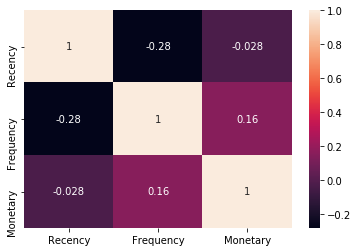

In [76]:
sns.heatmap(final2.corr(),annot=True)

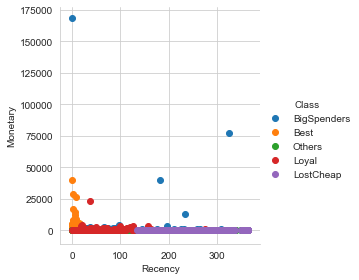

In [77]:
sns.set_style("whitegrid")
sns.FacetGrid(final2, hue="Class", height=4).map(plt.scatter, "Recency", "Monetary").add_legend()
plt.show()

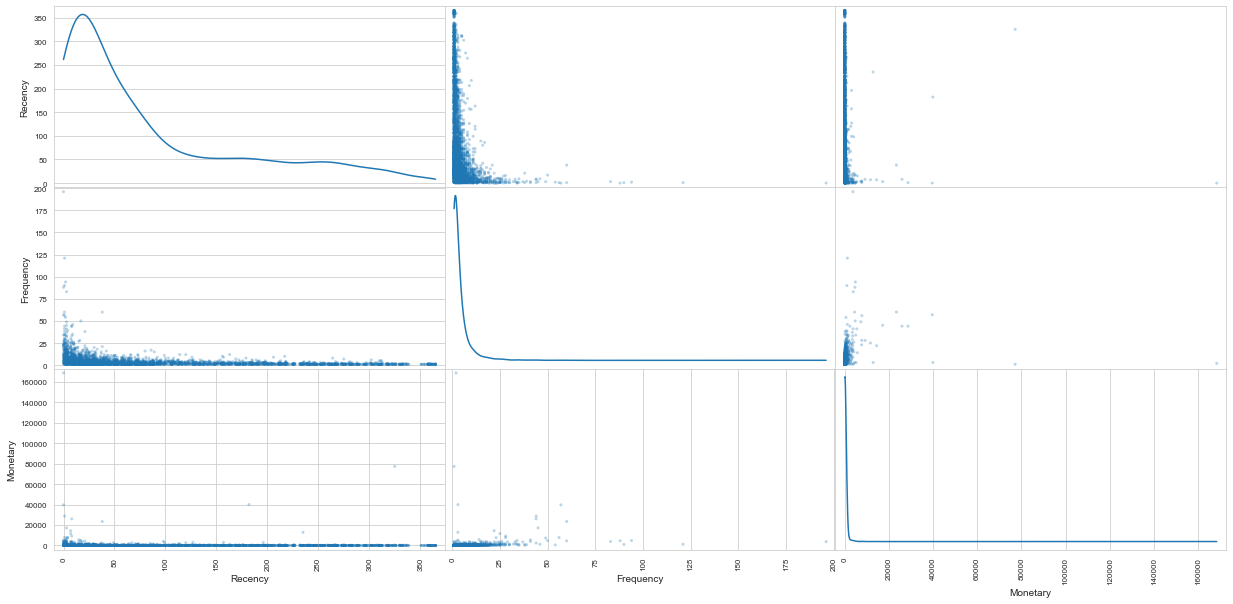

In [78]:
scatter_matrix(final2, alpha = 0.3, figsize = (21,10), diagonal = 'kde');

In [79]:
final2_r_log = np.log(final2['Recency']+0.1)
final2_f_log = np.log(final2['Frequency'])
final2_m_log = np.log(final2['Monetary']+0.1)
final2_c_log = final2['Class']

In [80]:
log_data=pd.DataFrame({'Monetary': final2_m_log,'Recency': final2_r_log,'Frequency': final2_f_log})

In [81]:
log_data['Class']=final2['Class']

In [82]:
log_data.head()

,Monetary,Recency,Frequency,Class
CustomerID,,,,
12346.0,11.253944,5.784133,0.000000,BigSpenders
12747.0,6.490708,0.741937,2.302585,Best
12748.0,8.226662,-2.302585,5.278115,Best
12749.0,4.589549,1.131402,1.609438,Others
12820.0,4.065602,1.131402,1.386294,Others


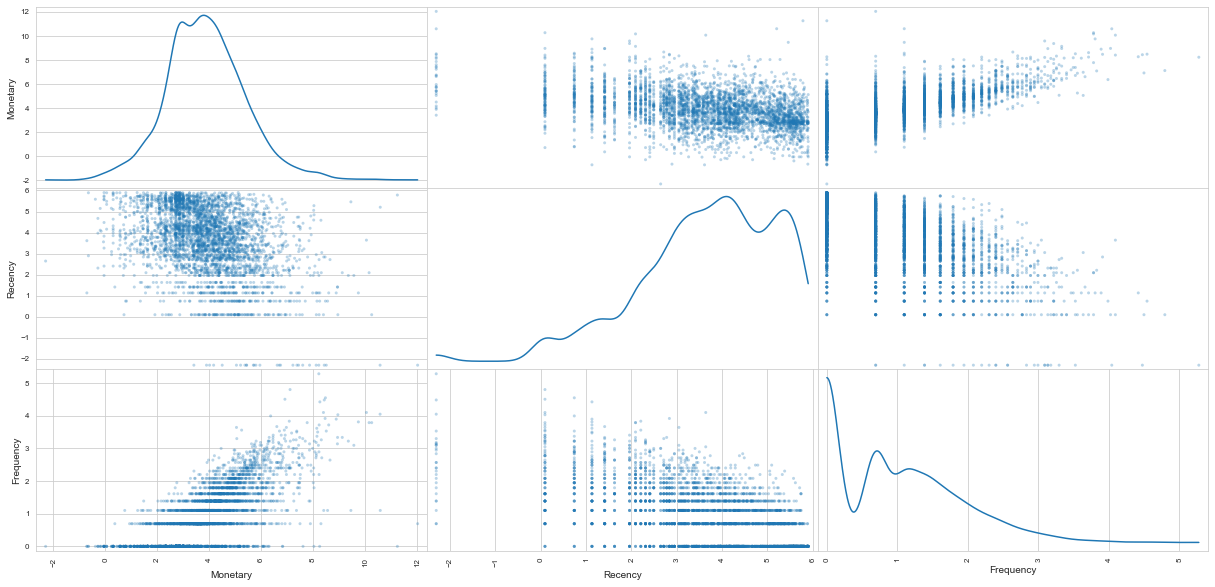

In [83]:
scatter_matrix(log_data, alpha = 0.3, figsize = (21,10), diagonal = 'kde');

In [84]:
array=log_data.values

In [85]:
X = array[:,0:2]
Y = array[:,3]
#validation_size = 0.20
#seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=0.2, random_state=47)

In [86]:
c=0.5;
#while(c<=10):
svm=SVC(kernel='rbf', C = c)
svm.fit(X_train, Y_train)
predictions = svm.predict(X_validation)
correct=0.0
for i in range(len(predictions)):
    if(predictions[i]==Y_validation[i]):
        correct+=1
accuracy=correct/len(predictions)
msg="C= %.1f -> accuracy = %f" % (c,accuracy)
print(msg)
#c+=0.1

C= 0.5 -> accuracy = 0.840880


In [87]:
svm=SVC(kernel='linear', C = c)
svm.fit(X_train, Y_train)
predictions = svm.predict(X_validation)
correct=0.0
for i in range(len(predictions)):
    if(predictions[i]==Y_validation[i]):
        correct+=1
accuracy=correct/len(predictions)
msg="C= %.1f -> accuracy = %f" % (c,accuracy)
print(msg)

C= 0.5 -> accuracy = 0.821475


Now we know our customer segment we can choose how to deal with each segment
i.e.,
Best customer **Reward them** ,they can be early adopter to a product. Suggest them `Refer a friend`.  
customer at risk- Send them personalised emails to encourage them to shop

To gain even further insight into customer behavior, we can dig deeper in the relationship between RFM variables.  

RFM model can be used in conjunction with certain predictive models like k-means clustering, Logistic Regression and Recommendation to produce better informative results on customer behavior.
  
We will go for k-means since it has been widely used for Market Segmentation and it offers the advantage of being simple to implement, following Andrew Ng who advice in his Machine Learning course, start with a dirty and simple model then move to more complex models because simple implementation helps having a first glance at the data and know where/how to exploit it better.

#### Applying K-means clustering on RFM variables

In [88]:
#RFM_df_UK.head()

In [89]:
rfm_data = RFM_df_UK.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore','Rank'],axis=1)
rfm_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


In [90]:
#feature correlation
rfm_data.corr()

,Recency,Frequency,Monetary
Recency,1.000000,-0.279236,-0.027727
Frequency,-0.279236,1.000000,0.156431
Monetary,-0.027727,0.156431,1.000000


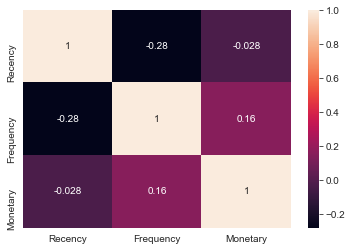

In [91]:
import seaborn as sns
#plt.figure(figsize=(8,5))
sns.heatmap(rfm_data.corr(),annot=True)
plt.show()

On one hand, we have a negative correlation between:

Recency and Frequency  
Recency and Monetary  
On the other hand, the correlation between Monetary and Frequency is positive comparing to negative ones but still not that strong.  

#### Visualize feature distributions
- To get a better understanding of the dataset, we can construct a scatter matrix of each of the three features present in the RFM data.

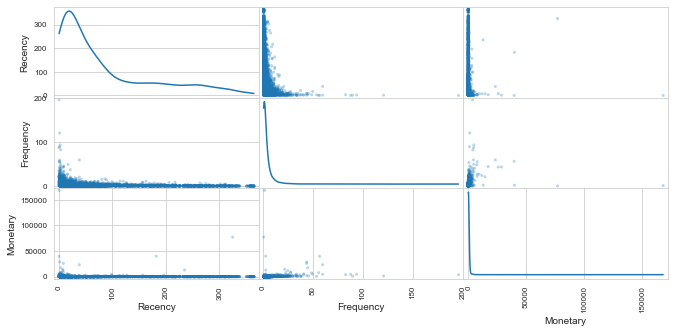

In [92]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(rfm_data, alpha = 0.3, figsize = (11,5), diagonal = 'kde');

we can notice that distribution is skewed and there are outlier, so we are required to do normalisation to make data feature distributed normally **as clustering algorithms require them to be normally dstributed.**

In [93]:
#Data normlaisation
##log(0) is undefined
rfm_r_log=np.log(rfm_data['Recency']+0.1)
rfm_f_log=np.log(rfm_data['Frequency'])
rfm_m_log=np.log(rfm_data['Monetary']+0.1)

In [94]:
norm_data=pd.DataFrame({'Monetary':rfm_m_log,
                       'Recency': rfm_r_log,
                       'Frequency': rfm_f_log})
norm_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,11.253944,5.784133,0.000000
12747.0,6.490708,0.741937,2.302585
12748.0,8.226662,-2.302585,5.278115
12749.0,4.589549,1.131402,1.609438
12820.0,4.065602,1.131402,1.386294


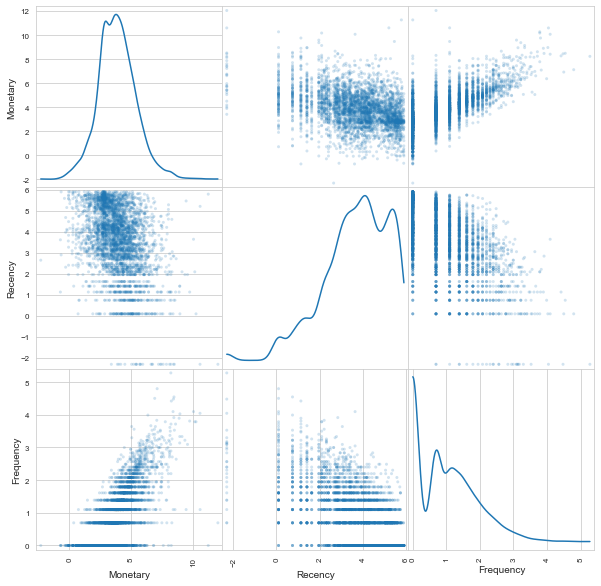

In [95]:
scatter_matrix(norm_data,alpha=0.2,figsize=(10,10),diagonal='kde');

The distribution of frequency ans monetary are more normalised. however, Recency is not improved as much

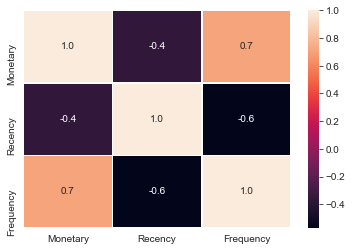

In [96]:
#plt.figure(figsize=(10,8))
sns.heatmap(norm_data.corr(),annot=True, linewidths=.5, fmt= '.1f')
plt.show()

In [97]:
norm_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,-0.364351,0.715609
Recency,-0.364351,1.000000,-0.569951
Frequency,0.715609,-0.569951,1.000000


now monetary and frequncy are more correlated

#### K-means Implementation
A common challenge with k-means is that you must tell it how many clusters you expect. Figuring out how many clusters we need is not obvious from data, thus we will try different clusters numbers and check their [silhouette coefficient](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). The elbow method can be used to determine the number of clusters as well.  

Note: K-means is sensitive to initializations because those initializations are critical to quality of optima found. Thus, we will use smart initialization called k-means++.  

In [98]:
matrix = norm_data.values
for n_clusters in range(2,11):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100,max_iter=300)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.3892687564859809
For n_clusters = 3 The average silhouette_score is : 0.3041444857998363
For n_clusters = 4 The average silhouette_score is : 0.3104685503819692
For n_clusters = 5 The average silhouette_score is : 0.29019589347459573
For n_clusters = 6 The average silhouette_score is : 0.29540469116063295
For n_clusters = 7 The average silhouette_score is : 0.291290144968737
For n_clusters = 8 The average silhouette_score is : 0.2915460803821681
For n_clusters = 9 The average silhouette_score is : 0.2947835371530078
For n_clusters = 10 The average silhouette_score is : 0.29842509965556624


The best silhouette score obtained is when the number of clusters is 2.

In [99]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print('Silhouette score: {:<.3f}'.format(silhouette_avg))

Silhouette score: 0.389


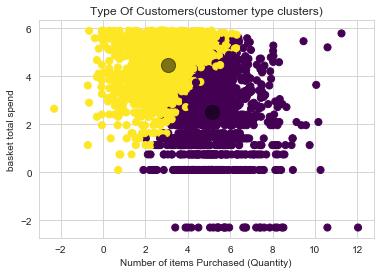

In [100]:
#visualise cluster
#create scatter plot
plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers, s=50, cmap='viridis')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('Type Of Customers(customer type clusters)')
plt.xlabel('Number of items Purchased (Quantity)')
plt.ylabel('basket total spend')
#plt.legend()
plt.show()

yellow cluster has centroid at (5,2.5) and purple has centroid at (2,4.2)

In [101]:
# What's the number of customers in each cluster?
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['Number of Customers']).T

,1,0
Number of Customers,2337,1526


#### Conclusion - Perspective after applying k-means clustering:

So, we will able to build a model that can classify new customers into low rank and high rank groups.

`Limitations of k-means clustering:`

- There is no assurance that it will lead to the global best solution.
- Can't deal with different shapes(not circular) and consider one point's probability of belonging to more than one cluster.  
These disadvantages of k-means mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope. Here comes Guassian Mixture Model (GMM) in help by providing greater flexibility due to clusters having unconstrained covariances and allowing probabilistic cluster assignment.
    
**Reference Python Data Science Handbook by Jake VanderPlas.**

Note- Further Explanation: A common practice before doing clustering: Principal Component Analysis (PCA). PCA calculates the dimensions which best maximize variance.It gives directions on how many components to consider for GMM. Basically, it does dimensionality reduction while keeping the most important features, characteristics (combinations of features best describe customers). But as we are not dealing with high dimension we won't do it for this case.

#### Gaussian Mixture Model Implementation
While k-means is easy to understand and implement.It fails when dealing with non-circular shapes and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.


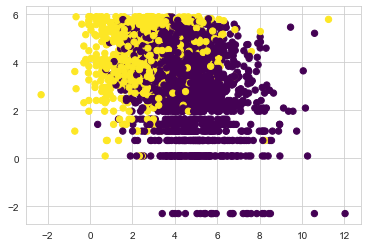

In [102]:
gmm = GaussianMixture(n_components=2).fit(matrix)
labels = gmm.predict(matrix)
plt.scatter(matrix[:, 0], matrix[:, 1], c=labels, s=40, cmap='viridis');

The GMM didn't provide a better result at this level than k-means.

#### Conclusion - Perspectives
- At this juncture, it makes sense to show interested stakeholders the cluster solutions and get their input.
- The decision should be based upon how the business plans to use the results, and the level of granularity they want to see in the clusters. What range of customer behavior from high-to-low value customers are the business stakeholders interested in exploring? 
- And from the answer to that question various methods of clustering can be further exploited whether applied on RFM variables or directly on the transaction dataset available.
- Missing customer ID - this column could be made not nullable, in case for treatment occurences of missing IDs.
- Unvalid Stock Codes (contains different letters/some words) - some checking constraints for stock codes.
- Duplicate transasctions - probably data were collected from multiple sources, which caused some duplictities.
- To each stock code should belong only one product description, this rule is not kept in dataset. The reason might be absence of constraints or wrong joins of the tables, if the dataset were constricted from multiple tables.
